In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [66]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-25 06:52:05--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M  --.-KB/s    in 0.07s   

2023-09-25 06:52:05 (19.0 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [67]:
df = pd.read_csv('/content/housing.csv')

In [68]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [69]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

<Axes: xlabel='median_house_value', ylabel='Count'>

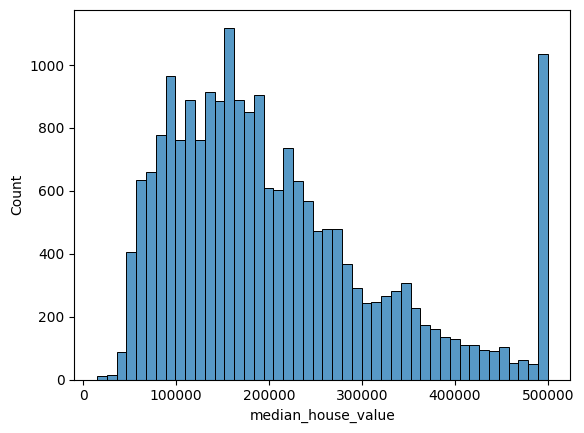

In [70]:
sns.histplot(df.median_house_value)

In [71]:
df = df[(df['ocean_proximity']=='<1H OCEAN') | (df['ocean_proximity']=='INLAND')]

In [72]:
del df['ocean_proximity']

In [73]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [74]:
np.median(df.population)

1195.0

In [75]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n-n_val-n_test

In [76]:
idx = np.arange(n)

In [77]:
np.random.seed(42)
np.random.shuffle(idx)

In [78]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [79]:
df['median_house_value'] = np.log1p(df.median_house_value)

<ipython-input-79-65d1db93622e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['median_house_value'] = np.log1p(df.median_house_value)


<Axes: xlabel='median_house_value', ylabel='Count'>

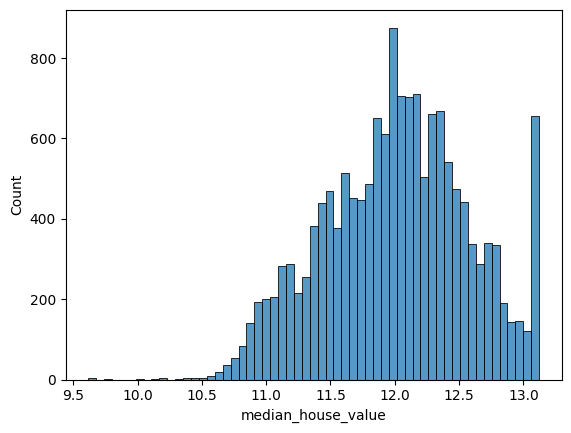

In [80]:
sns.histplot(df.median_house_value)

In [81]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [82]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [83]:
def train_linear_regression(X,y):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones,X])
  XTX = X.T.dot(X)
  XTX_inv = np.linalg.inv(XTX)

  w_full = XTX_inv.dot(X.T).dot(y)

  return w_full[0],w_full[1:]

In [84]:
#prepare X with filling 0 in total bedrooms missing value
def prepare_X_0(df):
  df = df.copy()
  df = df.fillna(0)
  X = df.values
  return X

In [85]:
def rmse(y,y_pred):
  se = (y-y_pred)**2
  mse = np.mean(se)
  rmse = np.sqrt(mse)
  return rmse

In [86]:
X_train = prepare_X_0(df_train)
w0, w = train_linear_regression(X_train,y_train)
y_pred = w0+X_train.dot(w)
score = rmse(y_train,y_pred)
score = round(score,2)
print(score)

0.34


In [87]:
def prepare_X(df):
  df = df.copy()
  mean = df.mean()
  df = df.fillna(mean)
  X = df.values
  return X

In [88]:
X_train = prepare_X_0(df_train)
w0, w = train_linear_regression(X_train,y_train)
y_pred = w0+X_train.dot(w)
score = rmse(y_train,y_pred)
score = round(score,2)
score

0.34

In [89]:
def train_linear_regression_reg(X,y,r=0.0):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones,X])
  XTX = X.T.dot(X)
  XTX = XTX+r*np.eye(XTX.shape[0])
  XTX_inv = np.linalg.inv(XTX)

  w_full = XTX_inv.dot(X.T).dot(y)

  return w_full[0],w_full[1:]

In [90]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
  X_train = prepare_X(df_train)
  w0, w = train_linear_regression_reg(X_train,y_train,r=r)
  X_val = prepare_X(df_val)
  y_pred = w0+X_val.dot(w)
  score = rmse(y_val,y_pred)
  score = round(score,2)
  print(r,w0,score)

0 -9.886133215653144 0.34
1e-06 -9.88611221896032 0.34
0.0001 -9.884033961199473 0.34
0.001 -9.86518070220252 0.34
0.01 -9.680528695172075 0.34
0.1 -8.154171163092915 0.34
1 -3.1633181812306983 0.34
5 -0.8483447454605789 0.35
10 -0.44183186814348235 0.35


So, r = 0.000001 is the best regularization value.

In [117]:
scores = []
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
  np.random.seed(i)
  np.random.shuffle(idx)
  df_train = df.iloc[idx[:n_train]]
  df_val = df.iloc[idx[n_train:n_train+n_val]]
  df_test = df.iloc[idx[n_train+n_val:]]
  y_train = np.log1p(df_train.median_house_value.values)
  y_val = np.log1p(df_val.median_house_value.values)
  y_test = np.log1p(df_test.median_house_value.values)
  del df_train['median_house_value']
  del df_val['median_house_value']
  del df_test['median_house_value']

  X_train = prepare_X_0(df_train)
  w0, w = train_linear_regression(X_train,y_train)
  X_val = prepare_X(df_val)
  y_pred = w0+X_val.dot(w)
  score = rmse(y_val,y_pred)
  scores.append(score)
std_score = np.std(scores)
round(std_score,4)

0.0005

In [113]:
np.random.seed(9)
np.random.shuffle(idx)
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']
df_full_train = pd.concat([df_train,df_val])
X_full_train = prepare_X_0(df_full_train)
y_full_train = np.concatenate([y_train,y_val])
w0, w = train_linear_regression_reg(X_full_train,y_full_train,r=0.001)
X_test = prepare_X_0(df_test)
y_pred = w0+X_test.dot(w)
score = rmse(y_test,y_pred)
score = round(score,3)
print(score)

0.026
